## Train and Evaulate Model

This notebook will train the model on the spectrogram input data and evaluate on the validation set 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import datetime

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import Reshape, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Dropout, Input, Add, Masking, Conv2D, MaxPooling2D, Concatenate, BatchNormalization, Activation
from keras import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.utils import plot_model
import keras.backend as backend

Define some constants

In [14]:
BATCH_SIZE = 32

SPECTROGRAM_LEN = 47
SPECTROGRAM_FREQS = 64
NUM_OUTPUT_CLASSES = 3

CONV_OUTPUT_LEN = 30

Define the common layers of the network

In [15]:
shared_conv1 = Conv2D(filters=8, kernel_size=3, padding='same')
shared_bn1 = BatchNormalization()
shared_relu1 = Activation('relu')
shared_mp1 = MaxPooling2D(pool_size=4, strides=4)
shared_do1 = Dropout(0.2)

shared_conv2 = Conv2D(filters=16, kernel_size=3, padding='same')
shared_bn2 = BatchNormalization()
shared_relu2 = Activation('relu')
shared_mp2 = MaxPooling2D(pool_size=4, strides=4)
shared_do2 = Dropout(0.2)

shared_flatten = Flatten()

shared_dense1 = Dense(units=CONV_OUTPUT_LEN)
shared_bn4 = BatchNormalization()
shared_relu4 = Activation('relu')

Define a function to load in the train, test, and validation data. Note that all NREM stages are combined into a single class, so this becomes a 3 class classification problem

In [16]:
def load_data(data_group):
    data = pickle.load(open('X_%s_spec.pkl' % data_group, 'rb'))
    labels = pickle.load(open('y_%s.pkl' % data_group, 'rb'))

    #combine NREM1, NREM2, NREM3, and NREM4 into a single class
    #new class definitions:
    #Wake = 0 originally, this remains the same
    #N1 = 1, N2 = 2, N3 = 3, N4 = 4 originally, now they are all assigned to the label of 1
    #REM = 5 originally, now REM = 2
    #Artifact/Unlabeled: N/A as any such labels were already removed in spectrogram generation
    three_class_labels = []
    for label in labels:
        label = np.array(label)
        label_2_inds = np.where(label==2)[0]
        label_3_inds = np.where(label==3)[0]
        label_4_inds = np.where(label==4)[0]
        label_5_inds = np.where(label==5)[0]

        label[label_2_inds] = 1
        label[label_3_inds] = 1
        label[label_4_inds] = 1
        label[label_5_inds] = 2

        three_class_labels.append(label)

    X1 = []
    X2 = []
    X3 = []
    X4 = []
    X5 = []
    y = []
    #y =
    for i in range(len(data)):
        X1_tmp = data[i][0]
        X2_tmp = data[i][1]
        X3_tmp = data[i][2]
        X4_tmp = data[i][3]
        X5_tmp = data[i][4]

        #make sure the size of the specgrogram is correct before adding it to the array
        #for some reason the third dimension of the spectrogram output is not right
        if (np.shape(X1_tmp)[2] != SPECTROGRAM_LEN) or (np.shape(X2_tmp)[2] != SPECTROGRAM_LEN) or (np.shape(X3_tmp)[2] != SPECTROGRAM_LEN) or (np.shape(X4_tmp)[2] != SPECTROGRAM_LEN) or (np.shape(X5_tmp)[2] != SPECTROGRAM_LEN):
            continue

        X1.append(X1_tmp)
        X2.append(X2_tmp)
        X3.append(X3_tmp)
        X4.append(X4_tmp)
        X5.append(X5_tmp)
        y.append(three_class_labels[i])


    X1 = np.array(X1).reshape(len(X1), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    X2 = np.array(X2).reshape(len(X2), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    X3 = np.array(X3).reshape(len(X3), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    X4 = np.array(X4).reshape(len(X4), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    X5 = np.array(X5).reshape(len(X5), SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2)
    y = to_categorical(y)

    return X1, X2, X3, X4, X5, y

Define a function to calculate the f1 score and confusion matrix

In [17]:
def performance_metrics(true, predictions, labels):
    #loop over each row, and then get the index corresponding to the max probability
    predictions_class = []
    for prediction in predictions:
        for row in prediction:
            predictions_class.append(np.argmax(row))

    #repeat for the true labels
    true_class = []
    for true_row in true:
        for row in true_row:
            true_class.append(np.argmax(row))

    #calculate confusion matrix
    conf_mat = confusion_matrix(true_class, predictions_class)
    conf_mat = pd.DataFrame(conf_mat, columns=labels, index=labels)

    #calculate per class f1
    f1 = f1_score(true_class, predictions_class, average=None)
    f1 = pd.Series(f1, index=labels)

    return conf_mat, f1, predictions_class, true_class

Define functions to build the CNN

In [18]:
def build_cnn(input):
    #build a cnn per channel
    cnn_output0 = build_cnn_per_channel(input, 0)
    cnn_output1 = build_cnn_per_channel(input, 1)

    #concatenate each channel's output
    cnn_output = Concatenate(axis=1)([cnn_output0, cnn_output1])
    cnn_output = Reshape((1,CONV_OUTPUT_LEN*2))(cnn_output)

    return cnn_output


def build_cnn_per_channel(input, ch):
    cnn_output = shared_conv1(input[:,:,:,ch][...,None])
    cnn_output = shared_bn1(cnn_output)
    cnn_output = shared_relu1(cnn_output)
    cnn_output = shared_mp1(cnn_output)
    cnn_output = shared_do1(cnn_output)
    cnn_output = shared_conv2(cnn_output)
    cnn_output = shared_bn2(cnn_output)
    cnn_output = shared_relu2(cnn_output)
    cnn_output = shared_mp2(cnn_output)
    cnn_output = shared_do2(cnn_output)
    cnn_output = shared_flatten(cnn_output)
    cnn_output = shared_dense1(cnn_output)
    cnn_output = shared_bn4(cnn_output)
    cnn_output = shared_relu4(cnn_output)
    cnn_output = Reshape((1,CONV_OUTPUT_LEN))(cnn_output)

    return cnn_output

Load in the training and validation data

In [19]:
X1_train, X2_train, X3_train, X4_train, X5_train, y_train = load_data('train')
X1_val, X2_val, X3_val, X4_val, X5_val, y_val = load_data('val')

Define the model architecture

In [20]:
input1 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))
input2 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))
input3 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))
input4 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))
input5 = Input(shape=(SPECTROGRAM_FREQS, SPECTROGRAM_LEN, 2))

cnn_output1 = build_cnn(input1)
cnn_output2 = build_cnn(input2)
cnn_output3 = build_cnn(input3)
cnn_output4 = build_cnn(input4)
cnn_output5 = build_cnn(input5)

#combine all five outputs into a single input for the LSTM
cnn_concat = Concatenate(axis=1)([cnn_output1, cnn_output2, cnn_output3, cnn_output4, cnn_output5])

lstm_output = Bidirectional(LSTM(15, return_sequences=True, kernel_regularizer=l2(0.01)))(cnn_concat)
lstm_output = Dense(NUM_OUTPUT_CLASSES, activation='softmax')(lstm_output)

model = Model(inputs=[input1, input2, input3, input4, input5], outputs=lstm_output)
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 47, 2)]          0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 64, 47, 2)]          0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 64, 47, 2)]          0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 64, 47, 2)]          0         []                            
                                                                                            

Train the model

In [21]:
#change this to true to train the model again
if False:
    checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='rmsprop')
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)
    history = model.fit([X1_train, X2_train, X3_train, X4_train, X5_train],
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=20,
                        validation_data=([X1_val, X2_val, X3_val, X4_val, X5_val], y_val),
                        callbacks=[earlystop, checkpoint, CSVLogger('history.csv')],
                        verbose=1)


model = load_model('model.h5')
history = pd.read_csv('history.csv')

Plot the loss and accuracy. Note that early stopping saved the model after epoch 8

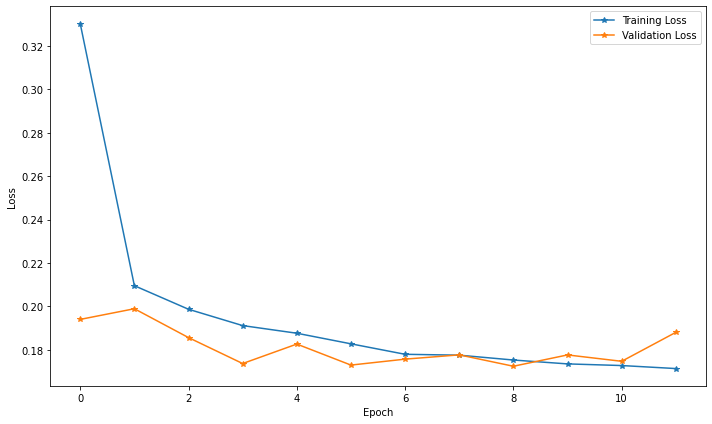

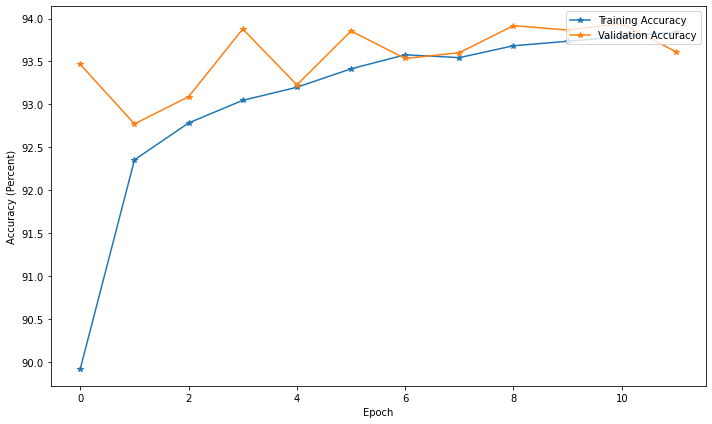

In [22]:
#plot the training and validation loss
plt.subplots(figsize=(10,6))
plt.plot(history['loss'], '*-', label='Training Loss')
plt.plot(history['val_loss'], '*-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('loss.png', dpi=150)
plt.show()

#plot the training and validation accuracy
plt.subplots(figsize=(10,6))
plt.plot(history['categorical_accuracy']*100, '*-', label='Training Accuracy')
plt.plot(history['val_categorical_accuracy']*100, '*-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Percent)')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('accuracy.png', dpi=150)
plt.show()

Evaluate the model on the test set

In [23]:
X1_test, X2_test, X3_test, X4_test, X5_test, y_test = load_data('test')
predictions = model.predict([X1_test, X2_test, X3_test, X4_test, X5_test])

#calculate confusion matrix and f1 scores
conf_mat, f1, _, _ = performance_metrics(y_test, predictions, ['Wake', 'NREM', 'REM'])

print('Confusion Matrix:')
print(conf_mat)

print('\nf1 score, per class:')
print(f1)

18/18 [==============================] - 2s 47ms/step
Confusion Matrix:
      Wake  NREM  REM
Wake  1863    66    0
NREM    37   468  203
REM      0   112    6

f1 score, per class:
Wake    0.973100
NREM    0.691285
REM     0.036697
dtype: float64


Generate an example output hypnogram and compare against the true values. This corresponds to subject SC4121EC from the test set.

18/18 [==============================] - 1s 48ms/step


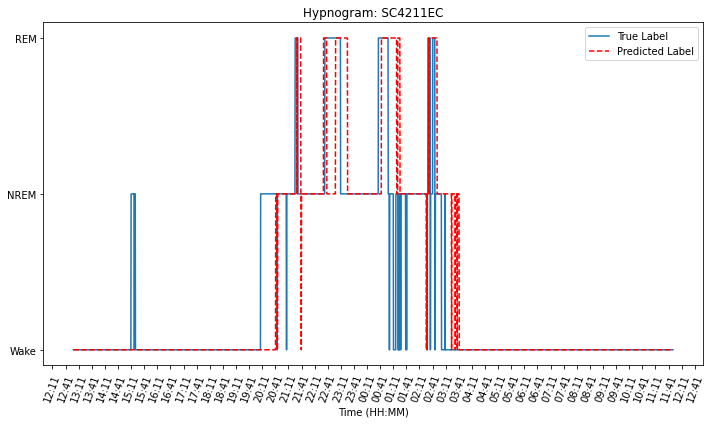

In [24]:
#get the predicted hypnogram for test set subject SC4481FV
X1_SC4211EC, X2_SC4211EC, X3_SC4211EC, X4_SC4211EC, X5_SC4211EC, y_SC4211EC = load_data('SC4211EC')
predictions = model.predict([X1_SC4211EC, X2_SC4211EC, X3_SC4211EC, X4_SC4211EC, X5_SC4211EC])

_, _, predictions_class, true_class = performance_metrics(y_SC4211EC, predictions, ['Wake', 'NREM', 'REM'])
fig, ax = plt.subplots(figsize=(10,6))
zero_time = datetime.datetime(2021,1,1,12,59,0)
timestamps = np.array([zero_time+datetime.timedelta(seconds=i*30) for i in range(len(predictions_class))])
plt.plot(timestamps, true_class, label='True Label')
plt.plot(timestamps, predictions_class, 'r--', label='Predicted Label')
plt.legend(loc=0)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=70)
ax.set_yticks([0,1,2])
ax.set_yticklabels(['Wake', 'NREM', 'REM'])
plt.xlabel('Time (HH:MM)')
plt.title('Hypnogram: SC4211EC')
plt.tight_layout()
plt.savefig('SC4211EC_hypnogram.png', dpi=250)
plt.show()